In [208]:
import pandas as pd
import warnings
import glob
import numpy as np
import scipy
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Partial Autocorrelation Function plots
from statsmodels.tsa.arima_model import ARIMA #tsa time series analysis
import statistics 
from pandas.plotting import autocorrelation_plot

from tbats import TBATS, BATS
from pmdarima import auto_arima
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_squared_error

In [3]:
sns.set()

In [2]:
# Read data 
tripdf=pd.DataFrame()
for filename in glob.glob("../Data_raw/Biketrips/*tripdata.csv"):
    tripdf=tripdf.append(pd.read_csv(filename, parse_dates=["starttime", "stoptime"]))

# Clean tripdf column names
tripdf.columns = tripdf.columns.str.replace(' ', '_')

# Take the columns of interest
trip_simp=tripdf[["start_station_id", "end_station_id", "starttime", "stoptime", 
                  "tripduration", "bikeid"]]

In [4]:
# Aggregate to have 
daily = trip_simp.set_index("starttime").resample("D").count().stoptime
weekly = trip_simp.set_index("starttime").resample("W").count().stoptime
monthly = trip_simp.set_index("starttime").resample("M").count().stoptime

In [13]:
# Monthly Average
monthly_ave=(monthly/[31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 
                   31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, # 2016
                   31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 
                   31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 
                   31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]) 

In [ ]:
# Maybe Monthly Average with Box-Cox transformation to handle increased variance a
monthly_ave_t=pd.Series(scipy.stats.boxcox(monthly_ave, lmbda=0.5), index=monthly.index)
monthly_ave.plot()

## Initial Timeseries Plots

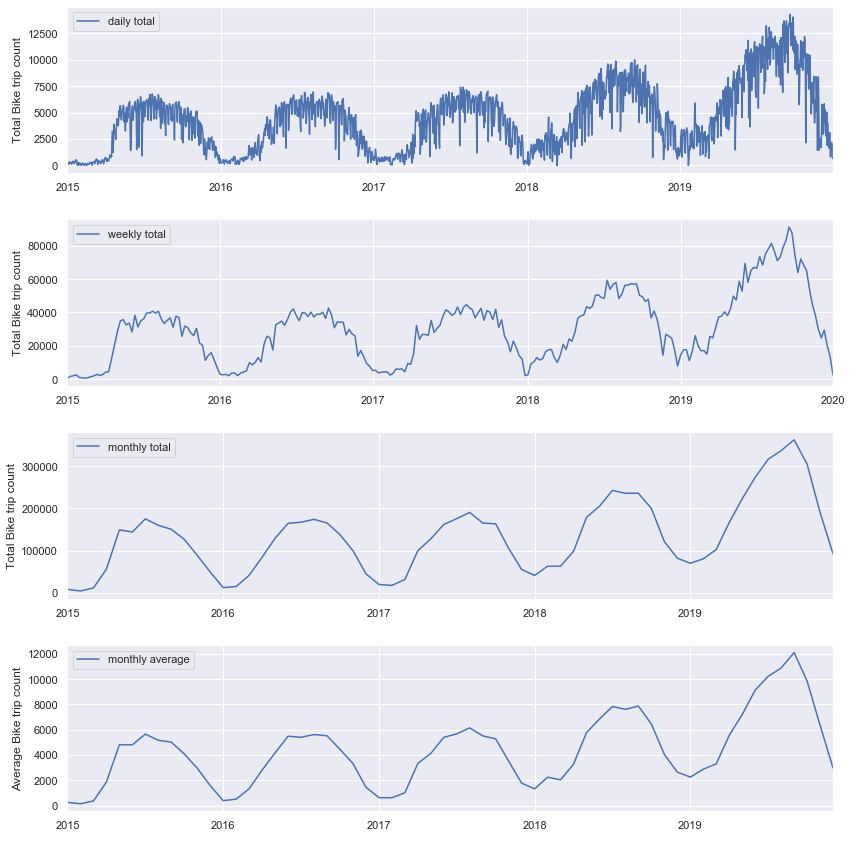

In [15]:
# Plot of daily, weekly, monthly
plt.subplots(figsize=(12,12))
plt.subplot(4,1,1)
daily.plot(label="daily total")
plt.xlabel(' ')
plt.ylabel("Total Bike trip count")
plt.legend()

plt.subplot(4,1,2)
weekly.plot(label="weekly total")
plt.xlabel(' ')
plt.ylabel("Total Bike trip count")
plt.legend()

plt.subplot(4,1,3)
monthly.plot(label="monthly total")
plt.xlabel(' ')
plt.ylabel("Total Bike trip count")
plt.legend()

plt.subplot(4,1,4)
monthly_ave.plot(label="monthly average")
plt.xlabel(' ')
plt.ylabel("Average Bike trip count")
plt.legend()
plt.tight_layout()


## Check if monthly_ave is stationary

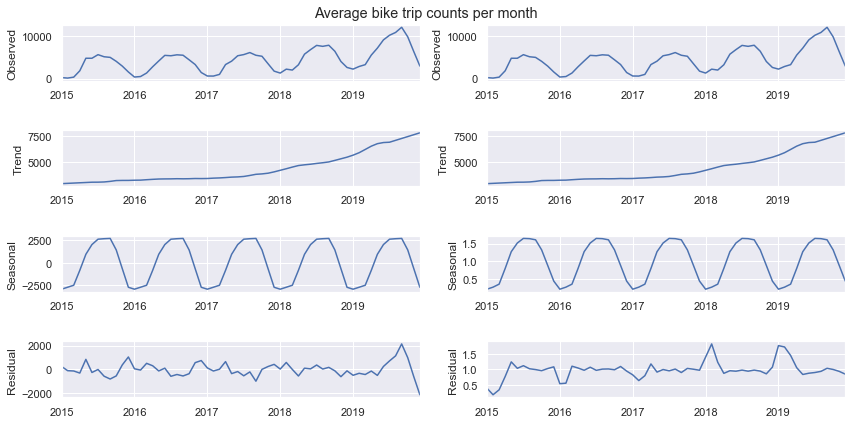

Test statistic = 2.7783
P-value = 1.0000
Critical values :
	1%: -3.5745892596209488 - The data is not stationary with 99% confidence
	5%: -2.9239543084490744 - The data is not stationary with 95% confidence
	10%: -2.6000391840277777 - The data is not stationary with 90% confidence


In [88]:
# decompositions

# It uses moving averages
decomp_add = sm.tsa.seasonal_decompose(monthly_ave, model='additive', extrapolate_trend='freq')
decomp_mult = sm.tsa.seasonal_decompose(monthly_ave, model='multiplicative', extrapolate_trend='freq')

fig, axes = plt.subplots(4, 2, figsize=(12,6))
decomp_add.observed.plot(ax=axes[0][0])
axes[0][0].set_ylabel("Observed")
axes[0][0].set_xlabel(" ")

decomp_add.trend.plot(ax=axes[1][0])
axes[1][0].set_ylabel("Trend")
axes[1][0].set_xlabel(" ")

decomp_add.seasonal.plot(ax=axes[2][0])
axes[2][0].set_ylabel("Seasonal")
axes[2][0].set_xlabel(" ")

decomp_add.resid.plot(ax=axes[3][0])
axes[3][0].set_ylabel("Residual")
axes[3][0].set_xlabel(" ")


decomp_mult.observed.plot(ax=axes[0][1])
axes[0][1].set_ylabel("Observed")
axes[0][1].set_xlabel(" ")

decomp_mult.trend.plot(ax=axes[1][1])
axes[1][1].set_ylabel("Trend")
axes[1][1].set_xlabel(" ")

decomp_mult.seasonal.plot(ax=axes[2][1])
axes[2][1].set_ylabel("Seasonal")
axes[2][1].set_xlabel(" ")

decomp_mult.resid.plot(ax=axes[3][1])
axes[3][1].set_ylabel("Residual")
axes[3][1].set_xlabel(" ")


plt.suptitle("Average bike trip counts per month", va="bottom")
plt.tight_layout()
plt.show()


# unit root test to see if the timeseries are stationary. 
# We cannot reject the null hypotehsis that unit root exists (not stationary )

dftest_monthly_ave = sm.tsa.stattools.adfuller(monthly_ave)
print("Test statistic = {:.4f}".format(dftest_monthly_ave[0]))
print("P-value = {:.4f}".format(dftest_monthly_ave[1]))
print("Critical values :")
for k, v in dftest_monthly_ave[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest_monthly_ave[0] else "", 100-int(k[:-1])))


## Before applying SARIMA, Check if weekly is stationary

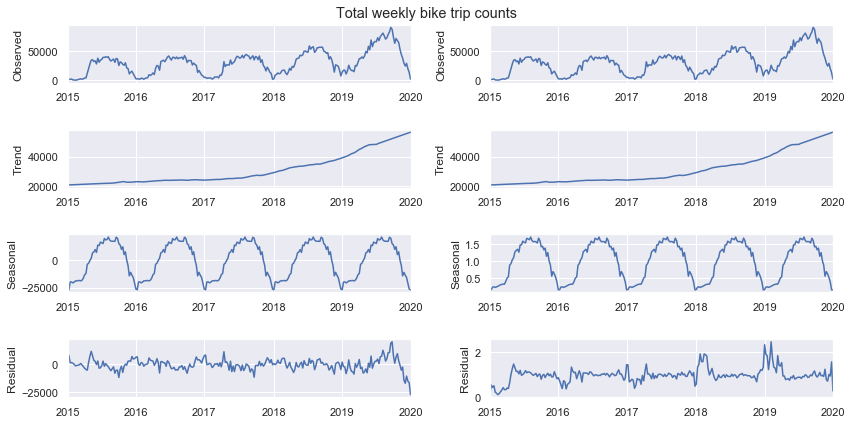

Test statistic = -5.1474
P-value = 0.0000
Critical values :
	1%: -3.4565688966099373 - The data is  stationary with 99% confidence
	5%: -2.8730786194395455 - The data is  stationary with 95% confidence
	10%: -2.5729189953388762 - The data is  stationary with 90% confidence


In [86]:
decomp_add = sm.tsa.seasonal_decompose(weekly, model='additive', extrapolate_trend='freq')
decomp_mult = sm.tsa.seasonal_decompose(weekly, model='multiplicative', extrapolate_trend='freq')

fig, axes = plt.subplots(4, 2, figsize=(12,6))
decomp_add.observed.plot(ax=axes[0][0])
axes[0][0].set_ylabel("Observed")
axes[0][0].set_xlabel(" ")

decomp_add.trend.plot(ax=axes[1][0])
axes[1][0].set_ylabel("Trend")
axes[1][0].set_xlabel(" ")

decomp_add.seasonal.plot(ax=axes[2][0])
axes[2][0].set_ylabel("Seasonal")
axes[2][0].set_xlabel(" ")

decomp_add.resid.plot(ax=axes[3][0])
axes[3][0].set_ylabel("Residual")
axes[3][0].set_xlabel(" ")


decomp_mult.observed.plot(ax=axes[0][1])
axes[0][1].set_ylabel("Observed")
axes[0][1].set_xlabel(" ")

decomp_mult.trend.plot(ax=axes[1][1])
axes[1][1].set_ylabel("Trend")
axes[1][1].set_xlabel(" ")

decomp_mult.seasonal.plot(ax=axes[2][1])
axes[2][1].set_ylabel("Seasonal")
axes[2][1].set_xlabel(" ")

decomp_mult.resid.plot(ax=axes[3][1])
axes[3][1].set_ylabel("Residual")
axes[3][1].set_xlabel(" ")

plt.suptitle("Total weekly bike trip counts", va="bottom")
plt.tight_layout()
plt.show()


dftest_weekly = sm.tsa.stattools.adfuller(weekly)
print("Test statistic = {:.4f}".format(dftest_weekly[0]))
print("P-value = {:.4f}".format(dftest_weekly[1]))
print("Critical values :")
for k, v in dftest_weekly[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest_weekly[0] else "", 100-int(k[:-1])))



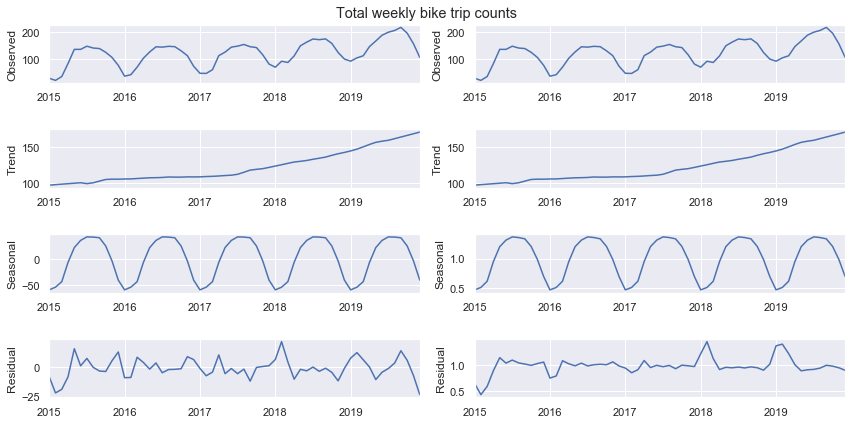

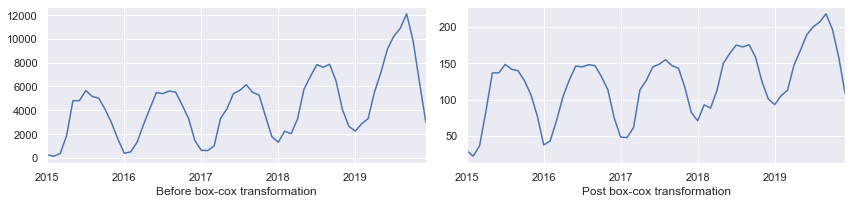

In [155]:
monthly_ave_t=pd.Series(scipy.stats.boxcox(monthly_ave, lmbda=0.5), index=monthly_ave.index)

decomp_add = sm.tsa.seasonal_decompose(monthly_ave_t, model='additive', extrapolate_trend='freq')
decomp_mult = sm.tsa.seasonal_decompose(monthly_ave_t, model='multiplicative', extrapolate_trend='freq')

fig, axes = plt.subplots(4, 2, figsize=(12,6))
decomp_add.observed.plot(ax=axes[0][0])
axes[0][0].set_ylabel("Observed")
axes[0][0].set_xlabel(" ")

decomp_add.trend.plot(ax=axes[1][0])
axes[1][0].set_ylabel("Trend")
axes[1][0].set_xlabel(" ")

decomp_add.seasonal.plot(ax=axes[2][0])
axes[2][0].set_ylabel("Seasonal")
axes[2][0].set_xlabel(" ")

decomp_add.resid.plot(ax=axes[3][0])
axes[3][0].set_ylabel("Residual")
axes[3][0].set_xlabel(" ")


decomp_mult.observed.plot(ax=axes[0][1])
axes[0][1].set_ylabel("Observed")
axes[0][1].set_xlabel(" ")

decomp_mult.trend.plot(ax=axes[1][1])
axes[1][1].set_ylabel("Trend")
axes[1][1].set_xlabel(" ")

decomp_mult.seasonal.plot(ax=axes[2][1])
axes[2][1].set_ylabel("Seasonal")
axes[2][1].set_xlabel(" ")

decomp_mult.resid.plot(ax=axes[3][1])
axes[3][1].set_ylabel("Residual")
axes[3][1].set_xlabel(" ")

plt.suptitle("Total weekly bike trip counts", va="bottom")
plt.tight_layout()
plt.show()


fig, axes=plt.subplots(1,2, figsize=(12,3))
monthly_ave.plot(ax=axes[0])
axes[0].set_xlabel("Before box-cox transformation")
monthly_ave_t.plot(ax=axes[1])
axes[1].set_xlabel("Post box-cox transformation")
plt.tight_layout()
plt.show()

## Check if daily is stationary
## Daily count has some 0 values and can't decompose multiplicatively

In [65]:
daily[daily==0]

starttime
2015-01-27    0
2015-02-09    0
2015-02-15    0
2018-03-13    0
2019-01-20    0
Name: stoptime, dtype: int64

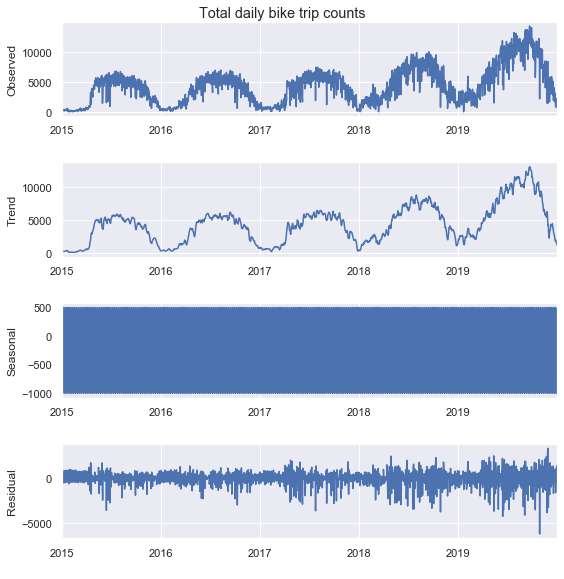

Test statistic = -2.4720
P-value = 0.1224
Critical values :
	1%: -3.4339881389288407 - The data is not stationary with 99% confidence
	5%: -2.863147035877915 - The data is not stationary with 95% confidence
	10%: -2.567625533641975 - The data is not stationary with 90% confidence


In [87]:
decomp_add = sm.tsa.seasonal_decompose(daily, model='additive', extrapolate_trend='freq')

fig, axes = plt.subplots(4, 1, figsize=(8,8))
decomp_add.observed.plot(ax=axes[0])
axes[0].set_ylabel("Observed")
axes[0].set_xlabel(" ")

decomp_add.trend.plot(ax=axes[1])
axes[1].set_ylabel("Trend")
axes[1].set_xlabel(" ")

decomp_add.seasonal.plot(ax=axes[2])
axes[2].set_ylabel("Seasonal")
axes[2].set_xlabel(" ")

decomp_add.resid.plot(ax=axes[3])
axes[3].set_ylabel("Residual")
axes[3].set_xlabel(" ")


plt.suptitle("Total daily bike trip counts", va="bottom")
plt.tight_layout()
plt.show()

    
dftest_daily = sm.tsa.stattools.adfuller(daily)
print("Test statistic = {:.4f}".format(dftest_daily[0]))
print("P-value = {:.4f}".format(dftest_daily[1]))
print("Critical values :")
for k, v in dftest_daily[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest_daily[0] else "", 100-int(k[:-1])))


## Focus on monthly_ave
* Shows increased variance -> Box-Cox transformation
* Shows a trend and it looks slow-exponential-> Detrend or difference 
* Shows seasonality -> seasonal difference


## Stationarizing the series

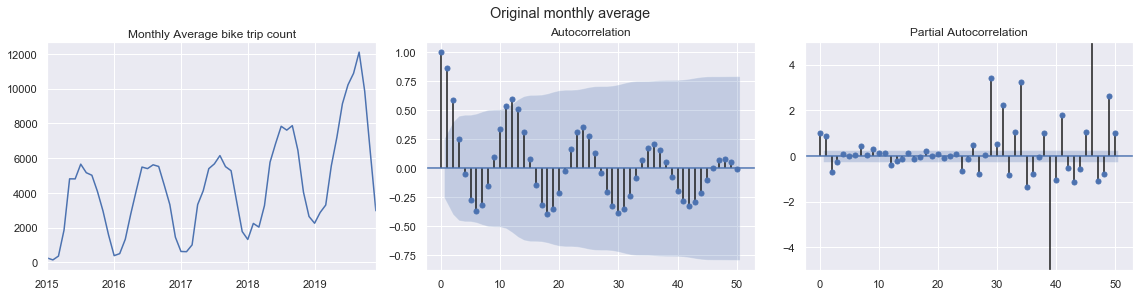

In [134]:
# Original monthly_ave

fig, axes = plt.subplots(1, 3, figsize=(16,4))
fig=monthly_ave.plot(ax=axes[0])
#axes[0].set_xlabel(" ")
axes[0].set_xlabel("Monthly Average bike trip count")
axes[0].xaxis.set_label_position("top")
fig=plot_acf(monthly_ave, lags=50, ax=axes[1]) 
fig=plot_pacf(monthly_ave, lags=50, ax=axes[2])
plt.ylim([-5,5])

plt.suptitle("Original monthly average", va="bottom")
plt.tight_layout()

(-5, 5)

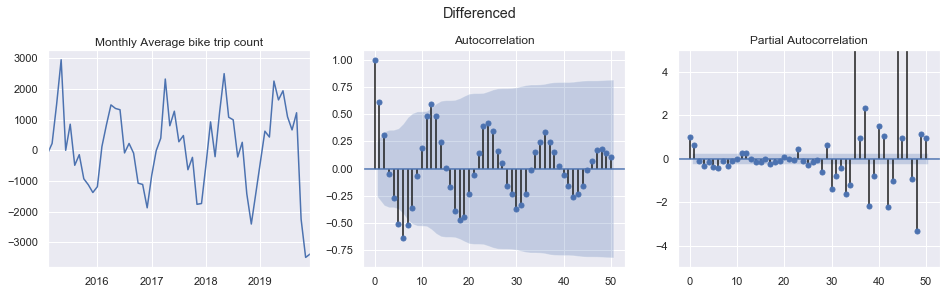

In [135]:
# Differenced once 
# Differencing can help stabilise the mean of a time series by removing changes in the level of a time series
fig, axes = plt.subplots(1, 2, figsize=(16,4))


fig=monthly_diff.plot( ax=axes[0])
axes[0].set_xlabel("Monthly Average bike trip count")
axes[0].xaxis.set_label_position("top")
monthly_diff=[]
for i in range(1, 60):
    monthly_diff.append(monthly_ave[i]-monthly_ave[i-1])
monthly_diff=pd.Series(monthly_diff, index=monthly.index[1:])


fig=plot_acf(monthly_diff, lags=50, ax=axes[1]) 
fig=plot_pacf(monthly_diff, lags=50, ax=axes[2])

plt.suptitle("Differenced", va="bottom")
plt.ylim([-5,5])

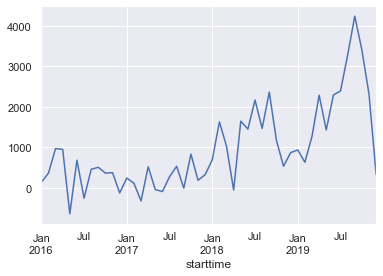

In [151]:
monthly_ssndiff.plot()

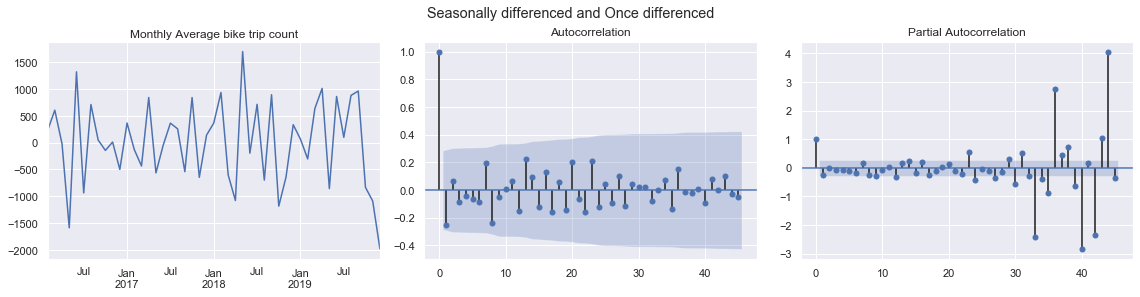

In [162]:
# seasonally differenced and differenced
fig, axes = plt.subplots(1, 3, figsize=(16,4))

# seasonal difference first
monthly_ssndiff = []
for i in range(12, 60):
    monthly_ssndiff.append(monthly_ave[i]-monthly_ave[i-12])
monthly_ssndiff=pd.Series(monthly_ssndiff, index=monthly.index[12:])

#difference once more
monthly_ssndiff_diff = []
for i in range(1, 48):
    monthly_ssndiff_diff.append(monthly_ssndiff[i]-monthly_ssndiff[i-1])
monthly_ssndiff_diff=pd.Series(monthly_ssndiff_diff, index=monthly.index[13:])


monthly_ssndiff_diff.plot(ax=axes[0])
axes[0].set_xlabel("Monthly Average bike trip count")
axes[0].xaxis.set_label_position("top")

fig=plot_acf(monthly_ssndiff_diff, lags=45, ax=axes[1]) 
fig=plot_pacf(monthly_ssndiff_diff, lags=45, ax=axes[2])

plt.suptitle("Seasonally differenced and Once differenced", va="bottom")
plt.tight_layout()


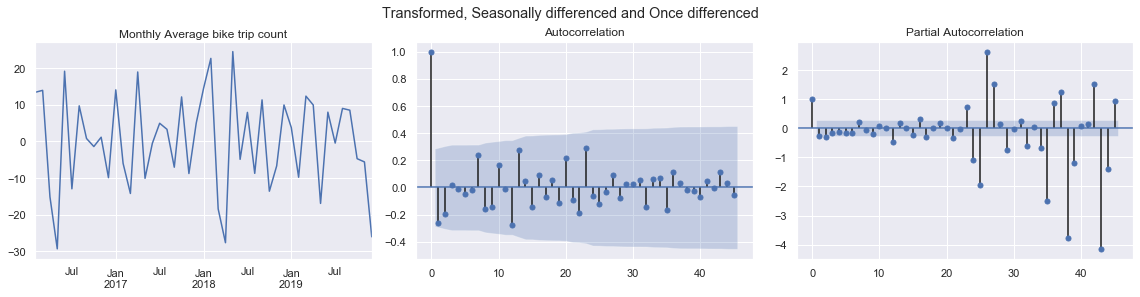

In [163]:
# trasnformed, seasonally differenced, differenced 
fig, axes = plt.subplots(1, 3, figsize=(16,4))

# seasonally differenced
monthly_ssndiff_t = []
for i in range(12, 60):
    monthly_ssndiff_t.append(monthly_ave_t[i]-monthly_ave_t[i-12])
monthly_ssndiff_t=pd.Series(monthly_ssndiff_t, index=monthly.index[12:])

# difference once more
monthly_ssndiff_t_diff = []
for i in range(1, 48):
    monthly_ssndiff_t_diff.append(monthly_ssndiff_t[i]-monthly_ssndiff_t[i-1])
monthly_ssndiff_t_diff=pd.Series(monthly_ssndiff_t_diff, index=monthly.index[13:])

fig=monthly_ssndiff_t_diff.plot(ax=axes[0])
axes[0].set_xlabel("Monthly Average bike trip count")
axes[0].xaxis.set_label_position("top")

fig=plot_acf(monthly_ssndiff_t_diff, lags=45, ax=axes[1]) 
fig=plot_pacf(monthly_ssndiff_t_diff, lags=45, ax=axes[2])

plt.suptitle("Transformed, Seasonally differenced and Once differenced", va="bottom")
plt.tight_layout()


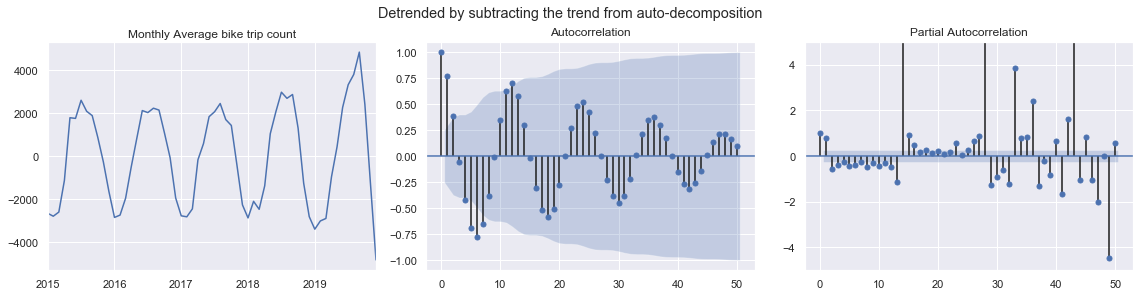

In [137]:
# Alternatively, try detrending
fig, axes = plt.subplots(1, 3, figsize=(16,4))
fig=(monthly_ave-decomp_add.trend).plot(ax=axes[0])
axes[0].set_xlabel("Monthly Average bike trip count")
axes[0].xaxis.set_label_position("top")
fig=plot_acf(monthly_ave-decomp_add.trend, lags=50, ax=axes[1]) 
fig=plot_pacf(monthly_ave-decomp_add.trend, lags=50, ax=axes[2])
plt.ylim([-5,5])
plt.suptitle("Detrended by subtracting the trend from auto-decomposition", va="bottom")
plt.tight_layout()

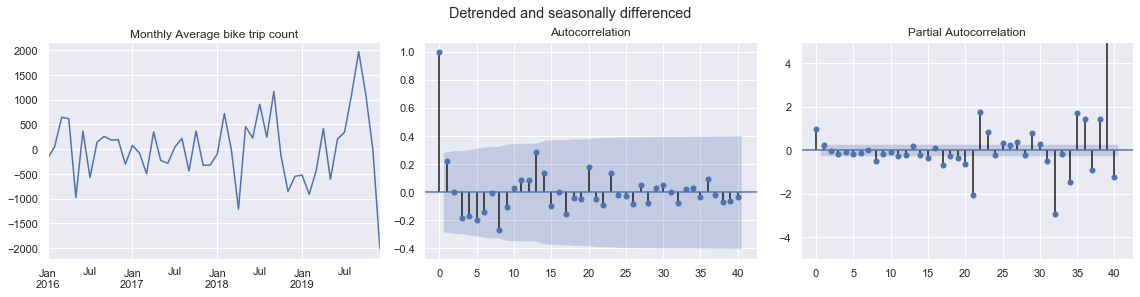

In [138]:
# Detrended and seasonally differenced
# most of the spikes are within 2/sqrt(length of timeseries) -> white noise.
fig, axes = plt.subplots(1, 3, figsize=(16,4))
monthly_ave_detrend = monthly_ave-decomp_add.trend
monthly_a_d_ssndiff = []
for i in range(12, 60):
    monthly_a_d_ssndiff.append(monthly_ave_detrend[i]-monthly_ave_detrend[i-12])
monthly_a_d_ssndiff=pd.Series(monthly_a_d_ssndiff, index=monthly.index[12:])

fig=monthly_a_d_ssndiff.plot(ax=axes[0])   
axes[0].set_xlabel("Monthly Average bike trip count")
axes[0].xaxis.set_label_position("top")
fig=plot_acf(monthly_a_d_ssndiff, lags=40, ax=axes[1]) 
fig=plot_pacf(monthly_a_d_ssndiff, lags=40, ax=axes[2])
plt.ylim([-5,5])
plt.suptitle("Detrended and seasonally differenced", va="bottom")
plt.tight_layout()

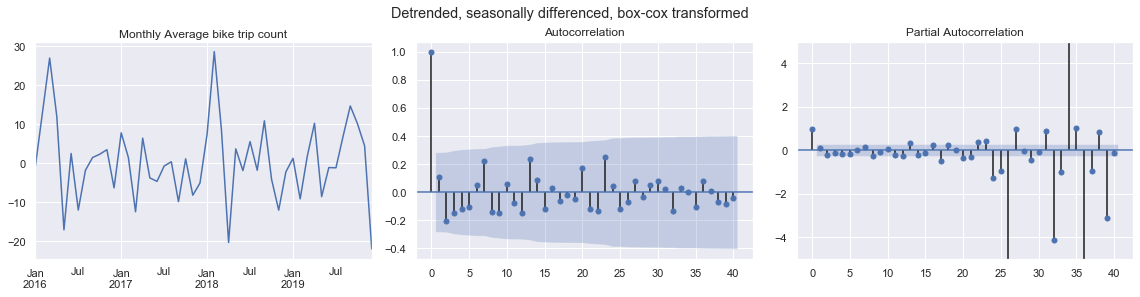

In [149]:
# Detrended, seasonally differenced, transformed

fig, axes = plt.subplots(1, 3, figsize=(16,4))
monthly_ave_detrend_t = monthly_ave_t-decomp_add.trend
monthly_a_d_ssndiff_t = []
for i in range(12, 60):
    monthly_a_d_ssndiff_t.append(monthly_ave_detrend_t[i]-monthly_ave_detrend_t[i-12])
monthly_a_d_ssndiff_t=pd.Series(monthly_a_d_ssndiff_t, index=monthly.index[12:])


fig=monthly_a_d_ssndiff_t .plot(ax=axes[0])   
axes[0].set_xlabel("Monthly Average bike trip count")
axes[0].xaxis.set_label_position("top")
fig=plot_acf(monthly_a_d_ssndiff_t , lags=40, ax=axes[1]) 
fig=plot_pacf(monthly_a_d_ssndiff_t , lags=40, ax=axes[2])
plt.ylim([-5,5])
plt.suptitle("Detrended, seasonally differenced, box-cox transformed", va="bottom")
plt.tight_layout()

## SARIMA Model 
* Can handle only one seasonality
* Difference order=1
* Seasonal difference order = 1, 2
* Grid-search

In [242]:
train_m = monthly_ave[:48]
test_m = monthly_ave[48:]

train_m_t=monthly_ave_t[:48]
test_m_t=monthly_ave_t[:48]

                                     SARIMAX Results                                      
Dep. Variable:                           stoptime   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -278.794
Date:                            Sat, 14 Mar 2020   AIC                            561.587
Time:                                    15:44:01   BIC                            564.698
Sample:                                01-31-2015   HQIC                           562.661
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.3562      0.176     -2.028      0.043      -0.700      -0.012
sigma2      4.986e+05   1.69e+05   

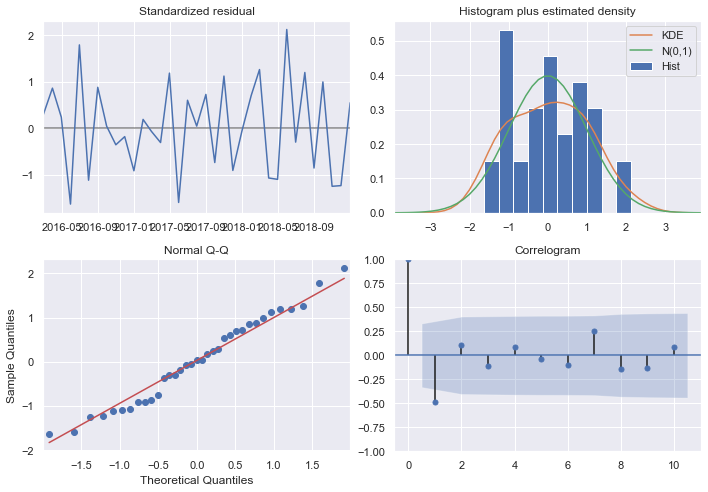

In [168]:
sarima1= sm.tsa.statespace.SARIMAX(train_m, order=(0,1,0), seasonal_order=(1,1,0,12))
result_sarima1 = sarima1.fit(disp=False)
print(result_sarima1.summary())
result_sarima1.plot_diagnostics(figsize=(10,7))
plt.tight_layout()
plt.show()
# Ljung box p < 0.05 the reject null 
# null hypotehsis: model is fine = does not show lack of fit = i.i.d 
# This portmanteau test. alternative is loosely stated 

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -140.127
Date:                            Sat, 14 Mar 2020   AIC                            284.255
Time:                                    16:47:54   BIC                            287.365
Sample:                                01-31-2015   HQIC                           285.329
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.2926      0.185     -1.583      0.113      -0.655       0.070
sigma2       170.5118     54.786   

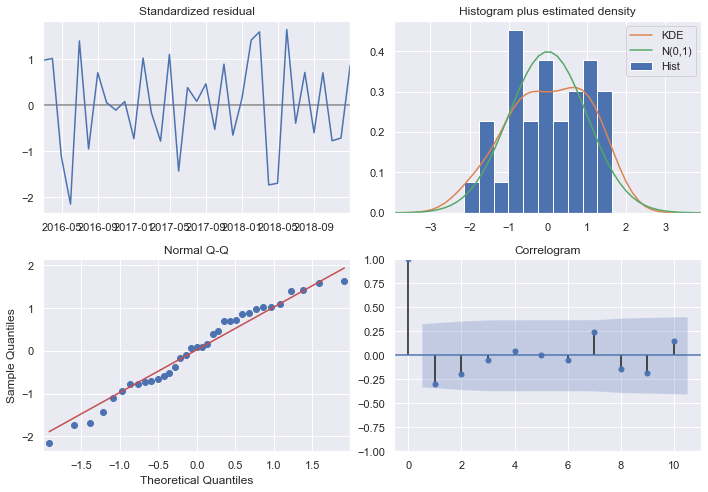

In [243]:
sarima1_t= sm.tsa.statespace.SARIMAX(train_m_t, order=(0,1,0), seasonal_order=(1,1,0,12))
result_sarima1_t = sarima1_t.fit(disp=False)
print(result_sarima1_t.summary())
result_sarima1_t.plot_diagnostics(figsize=(10,7))
plt.tight_layout()
plt.show()


                                      SARIMAX Results                                      
Dep. Variable:                            stoptime   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                -271.655
Date:                             Sat, 14 Mar 2020   AIC                            549.310
Time:                                     15:44:17   BIC                            553.976
Sample:                                 01-31-2015   HQIC                           550.920
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6796      0.132     -5.146      0.000      -0.938      -0.421
ar.S.L12      -0.3457      

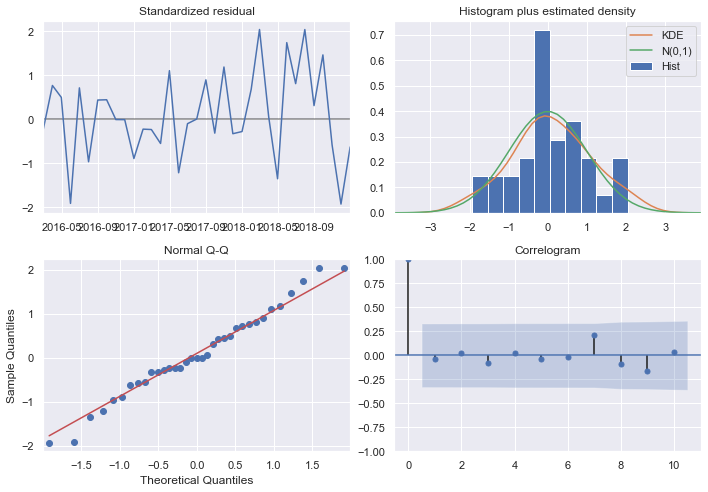

In [169]:
sarima2= sm.tsa.statespace.SARIMAX(train_m, order=(0,1,1), seasonal_order=(1,1,0,12))
result_sarima2 = sarima2.fit(disp=False)
print(result_sarima2.summary())
result_sarima2.plot_diagnostics(figsize=(10,7))
plt.tight_layout()
plt.show()

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                -135.192
Date:                             Sat, 14 Mar 2020   AIC                            276.383
Time:                                     16:49:02   BIC                            281.049
Sample:                                 01-31-2015   HQIC                           277.994
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7141      0.122     -5.833      0.000      -0.954      -0.474
ar.S.L12      -0.2818      

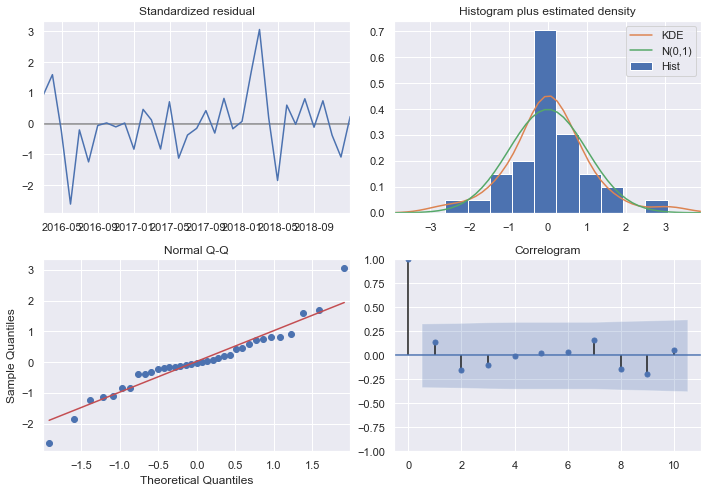

In [245]:
sarima2_t= sm.tsa.statespace.SARIMAX(train_m_t, order=(0,1,1), seasonal_order=(1,1,0,12))
result_sarima2_t = sarima2_t.fit(disp=False)
print(result_sarima2_t.summary())
result_sarima2_t.plot_diagnostics(figsize=(10,7))
plt.tight_layout()
plt.show()

                                      SARIMAX Results                                      
Dep. Variable:                            stoptime   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(1, 1, [], 12)   Log Likelihood                -270.990
Date:                             Sat, 14 Mar 2020   AIC                            549.979
Time:                                     16:24:36   BIC                            556.201
Sample:                                 01-31-2015   HQIC                           552.127
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift          1.2442      0.671      1.854      0.064      -0.071       2.560
ma.L1         -0.8213      

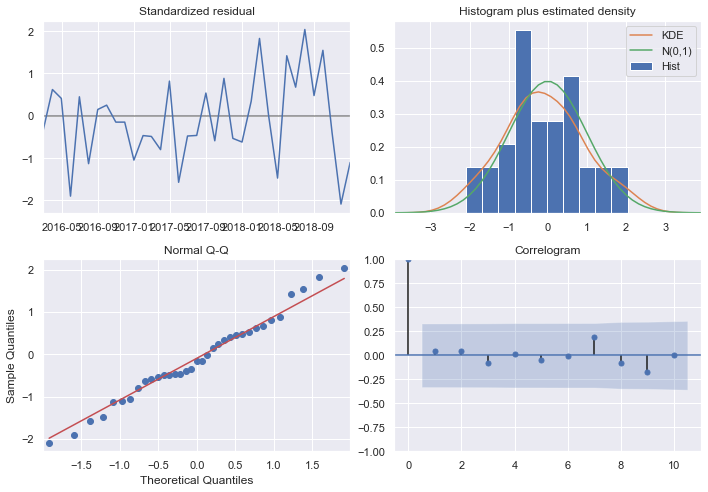

In [219]:
## TREND 
sarima2ct= sm.tsa.statespace.SARIMAX(train_m, order=(0,1,1), seasonal_order=(1,1,0,12), trend='t')
result_sarima2ct = sarima2ct.fit(disp=False)
print(result_sarima2ct.summary())
result_sarima2ct.plot_diagnostics(figsize=(10,7))
plt.tight_layout()
plt.show()

                                      SARIMAX Results                                      
Dep. Variable:                            stoptime   No. Observations:                   48
Model:             SARIMAX(0, 1, 2)x(1, 1, [], 12)   Log Likelihood                -271.640
Date:                             Sat, 14 Mar 2020   AIC                            551.279
Time:                                     15:47:25   BIC                            557.501
Sample:                                 01-31-2015   HQIC                           553.427
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6985      0.212     -3.294      0.001      -1.114      -0.283
ma.L2          0.0276      

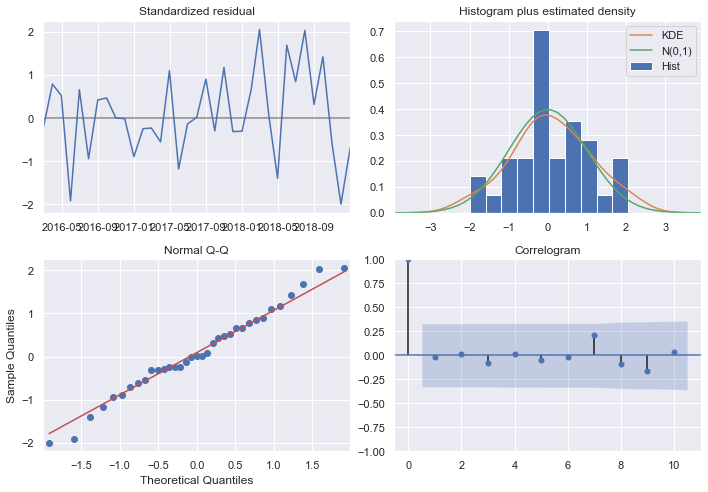

In [170]:
sarima3= sm.tsa.statespace.SARIMAX(train_m, order=(0,1,2), seasonal_order=(1,1,0,12))
result_sarima3 = sarima3.fit(disp=False)
print(result_sarima3.summary())
result_sarima3.plot_diagnostics(figsize=(10,7))
plt.tight_layout()
plt.show()

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(0, 1, 2)x(1, 1, [], 12)   Log Likelihood                -134.501
Date:                             Sat, 14 Mar 2020   AIC                            277.001
Time:                                     16:49:43   BIC                            283.223
Sample:                                 01-31-2015   HQIC                           279.149
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5644      0.309     -1.827      0.068      -1.170       0.041
ma.L2         -0.2143      

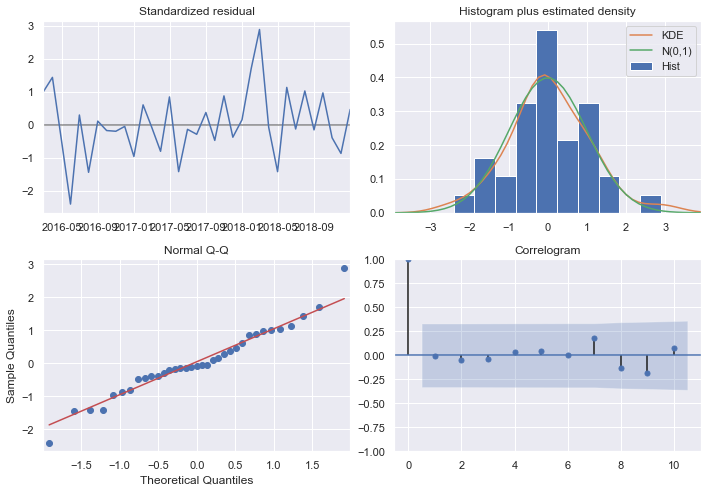

In [247]:
sarima3_t= sm.tsa.statespace.SARIMAX(train_m_t, order=(0,1,2), seasonal_order=(1,1,0,12))
result_sarima3_t = sarima3_t.fit(disp=False)
print(result_sarima3_t.summary())
result_sarima3_t.plot_diagnostics(figsize=(10,7))
plt.tight_layout()
plt.show()

                                      SARIMAX Results                                      
Dep. Variable:                            stoptime   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                -271.639
Date:                             Sat, 14 Mar 2020   AIC                            551.279
Time:                                     15:48:03   BIC                            557.500
Sample:                                 01-31-2015   HQIC                           553.426
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0429      0.229     -0.187      0.852      -0.493       0.407
ma.L1         -0.6568      

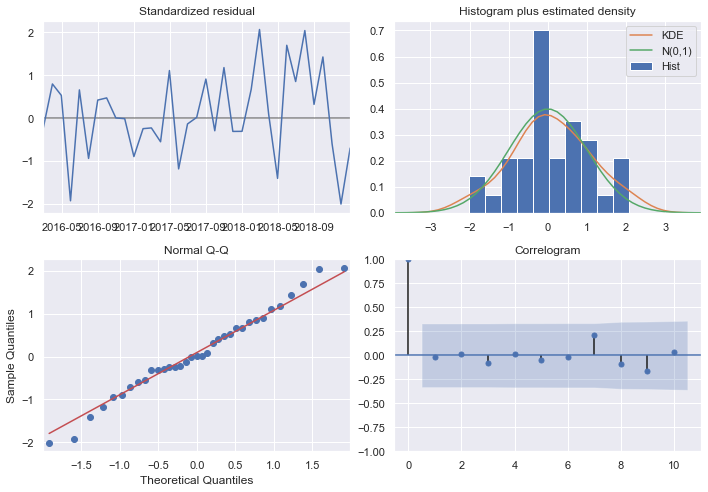

In [171]:
# branching from model 2
sarima4= sm.tsa.statespace.SARIMAX(train_m, order=(1,1,1), seasonal_order=(1,1,0,12))
result_sarima4 = sarima4.fit(disp=False)
print(result_sarima4.summary())
result_sarima4.plot_diagnostics(figsize=(10,7))
plt.tight_layout()
plt.show()

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood                -134.658
Date:                             Sat, 14 Mar 2020   AIC                            277.317
Time:                                     16:50:02   BIC                            283.538
Sample:                                 01-31-2015   HQIC                           279.465
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2409      0.320      0.753      0.452      -0.386       0.868
ma.L1         -0.8399      

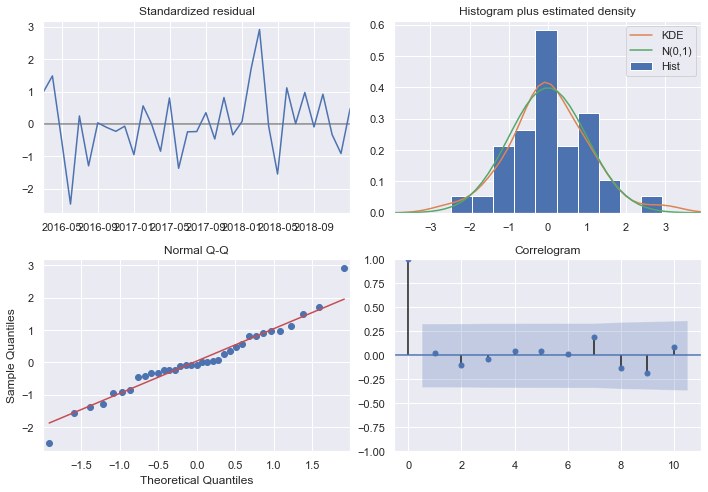

In [248]:
sarima4_t= sm.tsa.statespace.SARIMAX(train_m_t, order=(1,1,1), seasonal_order=(1,1,0,12))
result_sarima4_t = sarima4_t.fit(disp=False)
print(result_sarima4_t.summary())
result_sarima4_t.plot_diagnostics(figsize=(10,7))
plt.tight_layout()
plt.show()

                                      SARIMAX Results                                      
Dep. Variable:                            stoptime   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -272.864
Date:                             Sat, 14 Mar 2020   AIC                            549.729
Time:                                     15:49:32   BIC                            552.839
Sample:                                 01-31-2015   HQIC                           550.802
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6840      0.122     -5.590      0.000      -0.924      -0.444
sigma2      3.421e+05   8.7

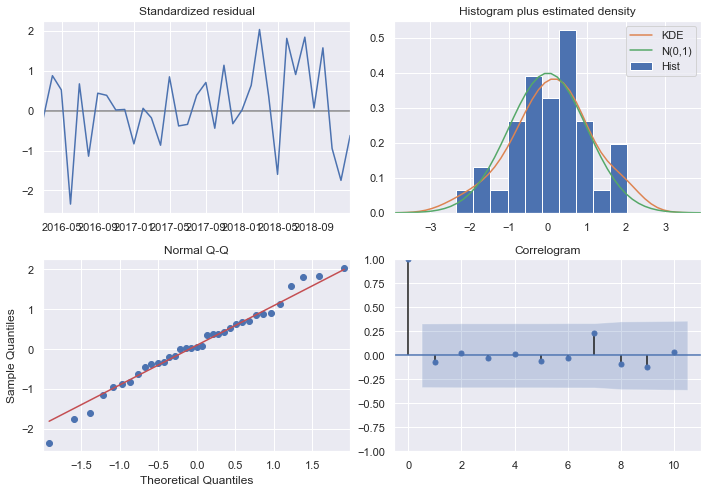

In [172]:
# branching from model 2
sarima5= sm.tsa.statespace.SARIMAX(train_m, order=(0,1,1), seasonal_order=(0,1,0,12))
result_sarima5 = sarima5.fit(disp=False)
print(result_sarima5.summary())
result_sarima5.plot_diagnostics(figsize=(10,7))
plt.tight_layout()
plt.show()

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, [], 12)   Log Likelihood                -135.850
Date:                             Sat, 14 Mar 2020   AIC                            275.700
Time:                                     16:50:47   BIC                            278.811
Sample:                                 01-31-2015   HQIC                           276.774
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7024      0.103     -6.812      0.000      -0.905      -0.500
sigma2       135.0498     2

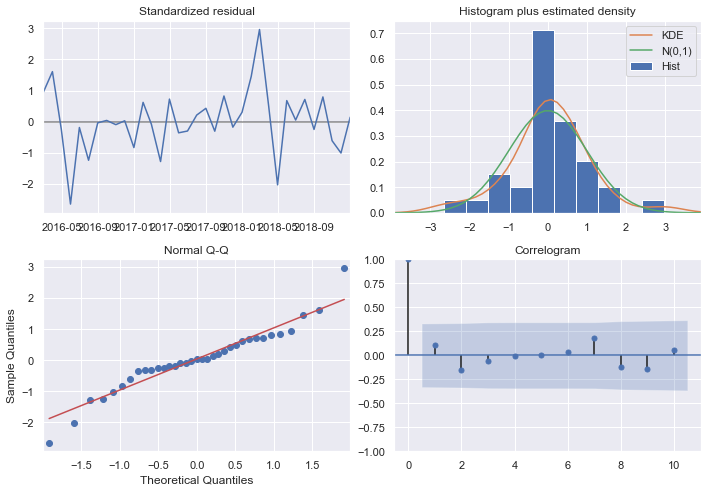

In [249]:
# BEST!! 
sarima5_t= sm.tsa.statespace.SARIMAX(train_m_t, order=(0,1,1), seasonal_order=(0,1,0,12))
result_sarima5_t = sarima5_t.fit(disp=False)
print(result_sarima5_t.summary())
result_sarima5_t.plot_diagnostics(figsize=(10,7))
plt.tight_layout()
plt.show()

                                      SARIMAX Results                                      
Dep. Variable:                            stoptime   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -269.751
Date:                             Sat, 14 Mar 2020   AIC                            547.502
Time:                                     15:50:43   BIC                            553.723
Sample:                                 01-31-2015   HQIC                           549.649
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6596      0.131     -5.036      0.000      -0.916      -0.403
ar.S.L12      -0.5031      

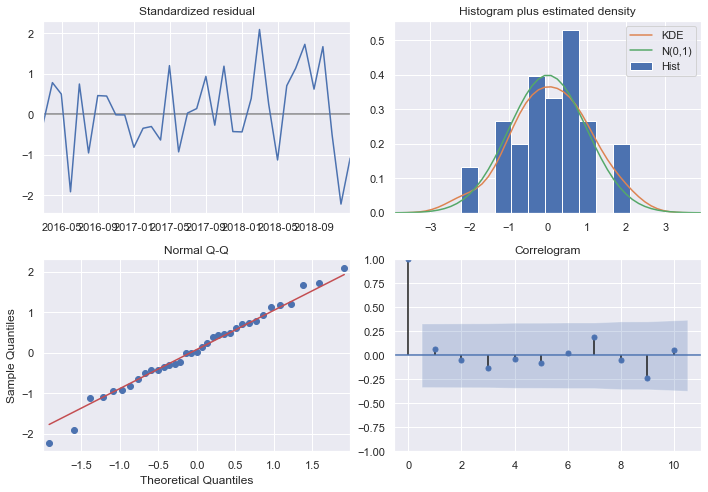

In [173]:
## BEST 
# branching from model 2
sarima6= sm.tsa.statespace.SARIMAX(train_m, order=(0,1,1), seasonal_order=(2,1,0,12))
result_sarima6 = sarima6.fit(disp=False)
print(result_sarima6.summary())
result_sarima6.plot_diagnostics(figsize=(10,7))
plt.tight_layout()
plt.show()
# p coefficient : each coefficient has no effect. 0.1 bigger than 0.05 but has some effect. 

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -135.134
Date:                             Sat, 14 Mar 2020   AIC                            278.269
Time:                                     16:51:10   BIC                            284.490
Sample:                                 01-31-2015   HQIC                           280.416
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7035      0.135     -5.222      0.000      -0.968      -0.439
ar.S.L12      -0.3226      

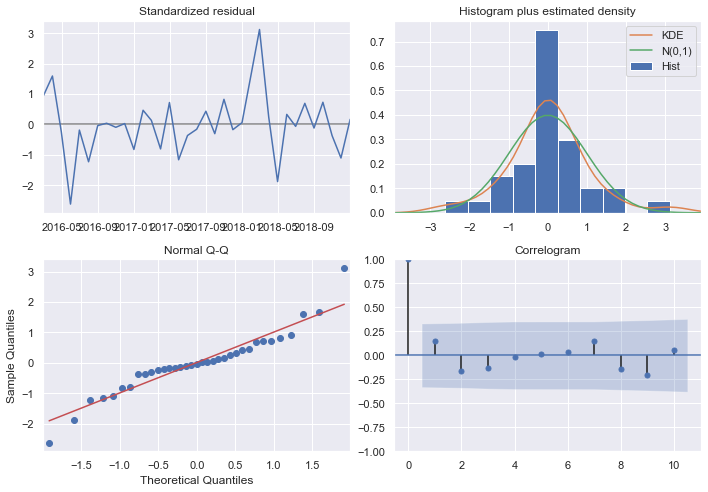

In [250]:
## BEST 
# branching from model 2
sarima6_t= sm.tsa.statespace.SARIMAX(train_m_t, order=(0,1,1), seasonal_order=(2,1,0,12))
result_sarima6_t = sarima6_t.fit(disp=False)
print(result_sarima6_t.summary())
result_sarima6_t.plot_diagnostics(figsize=(10,7))
plt.tight_layout()
plt.show()
# p coefficient : each coefficient has no effect. 0.1 bigger than 0.05 but has some effect. 

                                      SARIMAX Results                                      
Dep. Variable:                            stoptime   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -268.697
Date:                             Sat, 14 Mar 2020   AIC                            551.394
Time:                                     16:23:01   BIC                            562.282
Sample:                                 01-31-2015   HQIC                           555.152
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -694.1619   1259.972     -0.551      0.582   -3163.663    1775.339
drift         39.6419     6

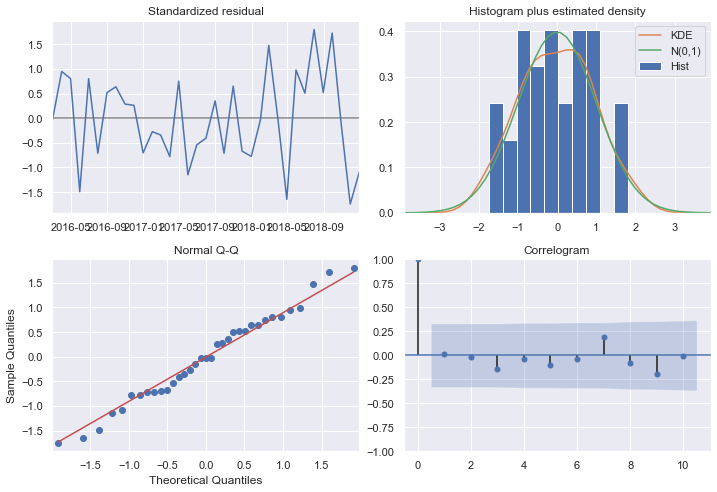

In [215]:
# with trend
sarima6ct= sm.tsa.statespace.SARIMAX(train_m, order=(0,1,1), seasonal_order=(2,1,0,12), trend=[1,1,1])
result_sarima6ct = sarima6ct.fit(disp=False)
print(result_sarima6ct.summary())
result_sarima6ct.plot_diagnostics(figsize=(10,7))
plt.tight_layout()
plt.show()
# p coefficient : each coefficient has no effect. 0.1 bigger than 0.05 but has some effect. 

/Users/kkim14/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                     SARIMAX Results                                      
Dep. Variable:                           stoptime   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -269.449
Date:                            Sat, 14 Mar 2020   AIC                            548.899
Time:                                    15:51:09   BIC                            556.675
Sample:                                01-31-2015   HQIC                           551.583
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6596      0.136     -4.848      0.000      -0.926      -0.393
ar.S.L12      -1.0791      0.320   

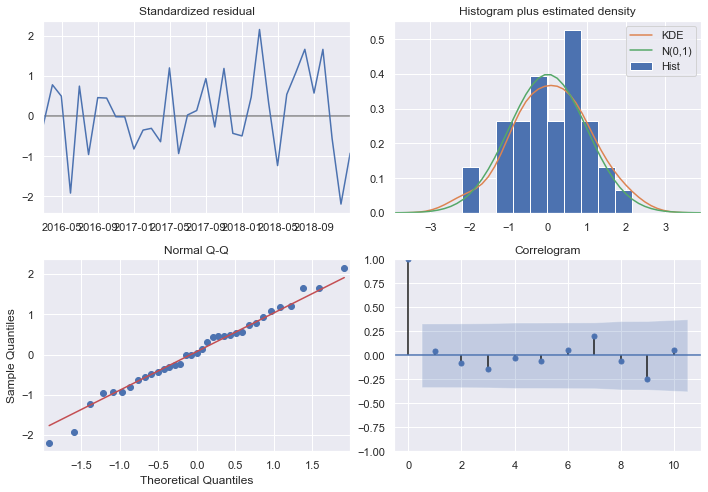

In [174]:
# branching from model 6  
sarima7= sm.tsa.statespace.SARIMAX(train_m, order=(0,1,1), seasonal_order=(2,1,1,12))
result_sarima7 = sarima7.fit(disp=False)
print(result_sarima7.summary())
result_sarima7.plot_diagnostics(figsize=(10,7))
plt.tight_layout()
plt.show()

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 12)   Log Likelihood                -135.134
Date:                            Sat, 14 Mar 2020   AIC                            280.269
Time:                                    16:51:52   BIC                            288.045
Sample:                                01-31-2015   HQIC                           282.953
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7035      0.136     -5.156      0.000      -0.971      -0.436
ar.S.L12      -0.1489   1.77e+04  -

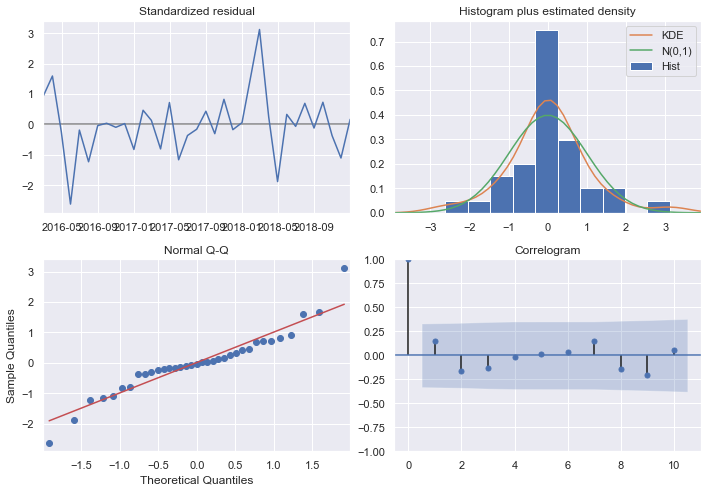

In [251]:
sarima7_t= sm.tsa.statespace.SARIMAX(train_m_t, order=(0,1,1), seasonal_order=(2,1,1,12))
result_sarima7_t = sarima7_t.fit(disp=False)
print(result_sarima7_t.summary())
result_sarima7_t.plot_diagnostics(figsize=(10,7))
plt.tight_layout()
plt.show()

                                      SARIMAX Results                                      
Dep. Variable:                            stoptime   No. Observations:                   48
Model:             SARIMAX(0, 1, 2)x(2, 1, [], 12)   Log Likelihood                -269.590
Date:                             Sat, 14 Mar 2020   AIC                            549.180
Time:                                     15:52:11   BIC                            556.957
Sample:                                 01-31-2015   HQIC                           551.865
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5944      0.229     -2.599      0.009      -1.043      -0.146
ma.L2         -0.0987      

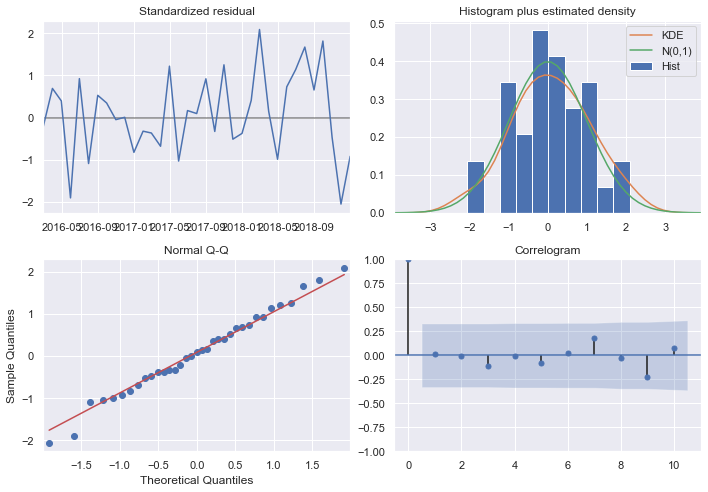

In [176]:
# branching from model 6
sarima8= sm.tsa.statespace.SARIMAX(train_m, order=(0,1,2), seasonal_order=(2,1,0,12))
result_sarima8 = sarima8.fit(disp=False)
print(result_sarima8.summary())
result_sarima8.plot_diagnostics(figsize=(10,7))
plt.tight_layout()
plt.show()

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(0, 1, 2)x(2, 1, [], 12)   Log Likelihood                -134.132
Date:                             Sat, 14 Mar 2020   AIC                            278.263
Time:                                     16:52:12   BIC                            286.040
Sample:                                 01-31-2015   HQIC                           280.948
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5052      0.351     -1.440      0.150      -1.193       0.183
ma.L2         -0.2817      

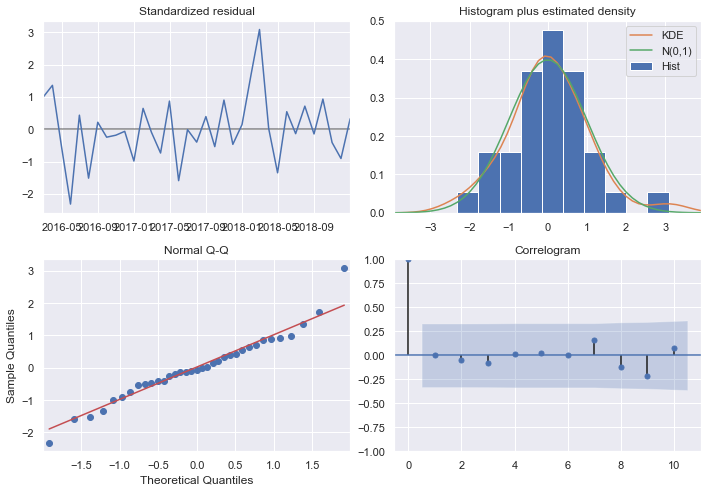

In [252]:
# branching from model 6
sarima8_t= sm.tsa.statespace.SARIMAX(train_m_t, order=(0,1,2), seasonal_order=(2,1,0,12))
result_sarima8_t = sarima8_t.fit(disp=False)
print(result_sarima8_t.summary())
result_sarima8_t.plot_diagnostics(figsize=(10,7))
plt.tight_layout()
plt.show()

                                      SARIMAX Results                                      
Dep. Variable:                            stoptime   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 12)   Log Likelihood                -269.583
Date:                             Sat, 14 Mar 2020   AIC                            549.165
Time:                                     15:52:45   BIC                            556.942
Sample:                                 01-31-2015   HQIC                           551.850
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1572      0.305      0.515      0.606      -0.441       0.755
ma.L1         -0.7463      

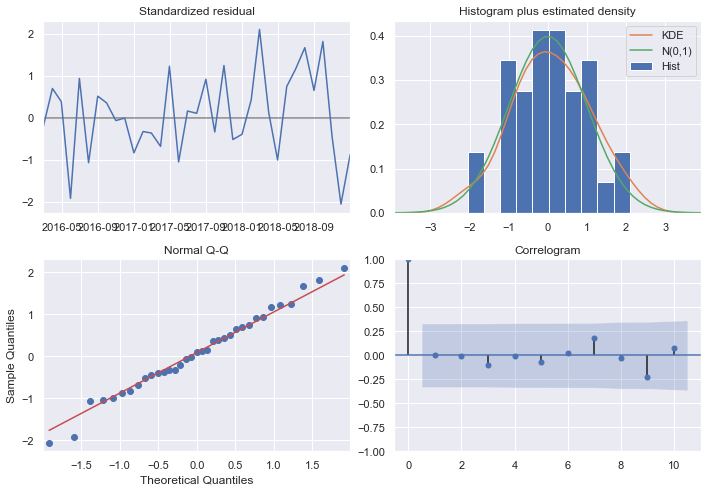

In [177]:
# branching from model 6
sarima9= sm.tsa.statespace.SARIMAX(train_m, order=(1,1,1), seasonal_order=(2,1,0,12))
result_sarima9 = sarima9.fit(disp=False)
print(result_sarima9.summary())
result_sarima9.plot_diagnostics(figsize=(10,7))
plt.tight_layout()
plt.show()

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   48
Model:             SARIMAX(1, 1, 1)x(2, 1, [], 12)   Log Likelihood                -134.390
Date:                             Sat, 14 Mar 2020   AIC                            278.780
Time:                                     16:53:15   BIC                            286.557
Sample:                                 01-31-2015   HQIC                           281.465
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3207      0.593      0.541      0.588      -0.841       1.482
ma.L1         -0.8799      

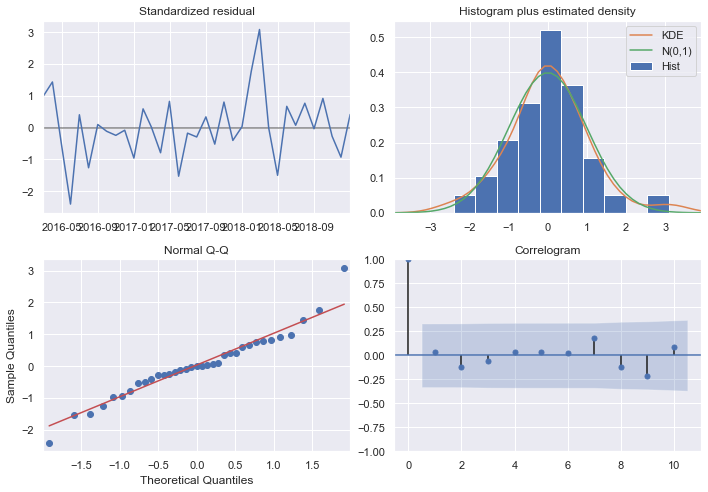

In [253]:
sarima9_t= sm.tsa.statespace.SARIMAX(train_m_t, order=(1,1,1), seasonal_order=(2,1,0,12))
result_sarima9_t = sarima9_t.fit(disp=False)
print(result_sarima9_t.summary())
result_sarima9_t.plot_diagnostics(figsize=(10,7))
plt.tight_layout()
plt.show()

In [199]:
pred_sarima1=result_sarima1.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_sarima2=result_sarima2.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_sarima3=result_sarima3.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_sarima4=result_sarima4.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_sarima5=result_sarima5.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_sarima6=result_sarima6.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_sarima7=result_sarima7.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_sarima8=result_sarima8.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_sarima9=result_sarima9.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)

In [256]:
pred_sarima1_t=result_sarima1_t.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_sarima2_t=result_sarima2_t.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_sarima3_t=result_sarima3_t.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_sarima4_t=result_sarima4_t.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_sarima5_t=result_sarima5_t.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_sarima6_t=result_sarima6_t.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_sarima7_t=result_sarima7_t.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_sarima8_t=result_sarima8_t.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)
pred_sarima9_t=result_sarima9_t.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2019-12-31'), dynamic=False)

In [197]:
pred_sarima1=pd.Series(pred_sarima1.predicted_mean, index=monthly_ave.index[48:])
print(mean_squared_error(monthly_ave[48:],pred_sarima1))

pred_sarima2=pd.Series(pred_sarima2.predicted_mean, index=monthly_ave.index[48:])
print(mean_squared_error(monthly_ave[48:],pred_sarima2))

pred_sarima3=pd.Series(pred_sarima3.predicted_mean, index=monthly_ave.index[48:])
print(mean_squared_error(monthly_ave[48:],pred_sarima3))

pred_sarima4=pd.Series(pred_sarima4.predicted_mean, index=monthly_ave.index[48:])
print(mean_squared_error(monthly_ave[48:],pred_sarima4))

pred_sarima5=pd.Series(pred_sarima5.predicted_mean, index=monthly_ave.index[48:])
print(mean_squared_error(monthly_ave[48:],pred_sarima5))

pred_sarima6=pd.Series(pred_sarima6.predicted_mean, index=monthly_ave.index[48:])
print(mean_squared_error(monthly_ave[48:],pred_sarima6))

pred_sarima7=pd.Series(pred_sarima7.predicted_mean, index=monthly_ave.index[48:])
print(mean_squared_error(monthly_ave[48:],pred_sarima7))

pred_sarima8=pd.Series(pred_sarima8.predicted_mean, index=monthly_ave.index[48:])
print(mean_squared_error(monthly_ave[48:],pred_sarima8))

pred_sarima9=pd.Series(pred_sarima9.predicted_mean, index=monthly_ave.index[48:])
print(mean_squared_error(monthly_ave[48:],pred_sarima9))



3862174.7397359363
3144652.2712180964
3164531.293147808
3169000.5144574777
2196221.050984
3815443.84853669
3798318.481038114
3801801.136399407
3832352.0267451103


In [259]:
pred_sarima1_ts=pd.Series(scipy.special.inv_boxcox(pred_sarima1_t.predicted_mean, 0.5), index=monthly_ave.index[48:])
print(mean_squared_error(monthly_ave[48:],pred_sarima1_ts))

pred_sarima2_ts=pd.Series(scipy.special.inv_boxcox(pred_sarima2_t.predicted_mean, 0.5), index=monthly_ave.index[48:])
print(mean_squared_error(monthly_ave[48:],pred_sarima2_ts))

pred_sarima3_ts=pd.Series(scipy.special.inv_boxcox(pred_sarima3_t.predicted_mean, 0.5), index=monthly_ave.index[48:])
print(mean_squared_error(monthly_ave[48:],pred_sarima3_ts))

pred_sarima4_ts=pd.Series(scipy.special.inv_boxcox(pred_sarima4_t.predicted_mean, 0.5), index=monthly_ave.index[48:])
print(mean_squared_error(monthly_ave[48:],pred_sarima4_ts))

pred_sarima5_ts=pd.Series(scipy.special.inv_boxcox(pred_sarima5_t.predicted_mean, 0.5), index=monthly_ave.index[48:])
print(mean_squared_error(monthly_ave[48:],pred_sarima5_ts))

pred_sarima6_ts=pd.Series(scipy.special.inv_boxcox(pred_sarima6_t.predicted_mean, 0.5), index=monthly_ave.index[48:])
print(mean_squared_error(monthly_ave[48:],pred_sarima6_ts))

pred_sarima7_ts=pd.Series(scipy.special.inv_boxcox(pred_sarima7_t.predicted_mean, 0.5), index=monthly_ave.index[48:])
print(mean_squared_error(monthly_ave[48:],pred_sarima7_ts))

pred_sarima8_ts=pd.Series(scipy.special.inv_boxcox(pred_sarima8_t.predicted_mean, 0.5), index=monthly_ave.index[48:])
print(mean_squared_error(monthly_ave[48:],pred_sarima8_ts))

pred_sarima9_ts=pd.Series(scipy.special.inv_boxcox(pred_sarima9_t.predicted_mean, 0.5), index=monthly_ave.index[48:])
print(mean_squared_error(monthly_ave[48:],pred_sarima9_ts))







1855641.2983687895
2164965.830359901
2221929.666645708
2295208.7348500197
1503631.280215676
2296282.958040627
2272665.533637497
2511973.510378615
2684571.6341719935


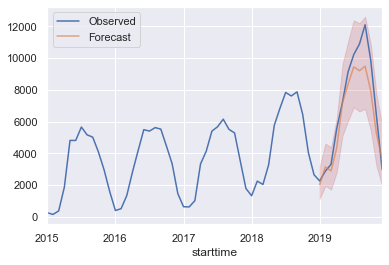

In [261]:
# BEST 
pred_sarima5_confint_ts = scipy.special.inv_boxcox(pred_sarima5_t.conf_int(), 0.5)

ax = monthly_ave.plot(label='Observed')
pred_sarima5_ts.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_sarima5_confint_ts.index,
                pred_sarima5_confint_ts.iloc[:, 0],
                pred_sarima5_confint_ts.iloc[:, 1], color='r', alpha=.2)
plt.legend()
plt.show()

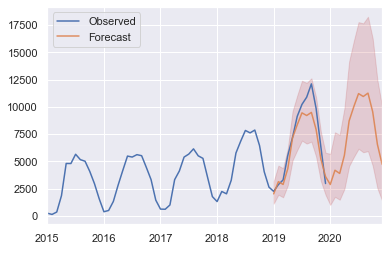

In [310]:
future=result_sarima5_t.get_prediction(start=pd.to_datetime('2019-01-31'), end=pd.to_datetime('2020-12-31'))
future_ts = scipy.special.inv_boxcox(future.conf_int(), 0.5)
ax = monthly_ave.plot(label='Observed')
scipy.special.inv_boxcox(future.predicted_mean, 0.5).plot(ax=ax, label='Forecast', alpha=.9)

ax.fill_between(future.predicted_mean.index,
                future_ts.iloc[:, 0],
                future_ts.iloc[:, 1], color='r', alpha=.2)
plt.legend(loc="upper left")
plt.xlabel(" ")
plt.show()

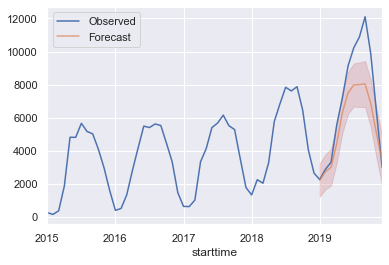

In [180]:
pred_sarima6_confint = pred_sarima6.conf_int()

ax = monthly_ave.plot(label='Observed')
pred_sarima6.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

ax.fill_between(pred_sarima6_confint.index,
                pred_sarima6_confint.iloc[:, 0],
                pred_sarima6_confint.iloc[:, 1], color='r', alpha=.2)
plt.legend()
plt.show()

## Naive seasonal-Base model!

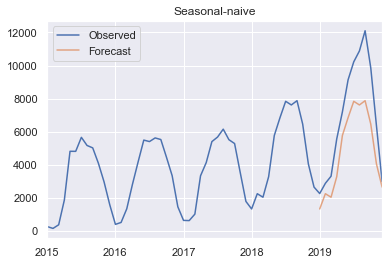

RMSE:  5558064.068130831


In [221]:
pred_naive = pd.Series(monthly_ave[36:48].values, index=monthly_ave.index[48:])

ax = monthly_ave.plot(label='Observed')
pred_naive.plot(ax=ax, label='Forecast', alpha=.7)

plt.title("Seasonal-naive")
plt.xlabel(" ")
plt.legend()
plt.show()

print("RMSE: ", mean_squared_error(monthly_ave[48:],pred_naive))

## Auto-Arima

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -269.970
Date:                            Sat, 14 Mar 2020   AIC                            547.940
Time:                                    17:53:49   BIC                            554.162
Sample:                                         0   HQIC                           550.088
                                             - 48                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     22.1988     21.388      1.038      0.299     -19.720      64.118
ma.L1         -0.7604      0.152   

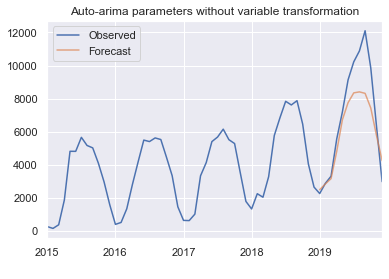

In [308]:
arima_model = auto_arima(train_m, seasonal=True, m=12)
print(arima_model.summary())


y_arima_forecast = arima_model.predict(n_periods=12)
auto=pd.Series(y_arima_forecast, index=monthly_ave.index[48:])
ax = monthly_ave.plot(label='Observed')
auto.plot(ax=ax, label='Forecast', alpha=.7)
plt.legend()
plt.title("Auto-arima parameters without variable transformation")
plt.xlabel(" ")
plt.show()


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   48
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -195.565
Date:                            Sat, 14 Mar 2020   AIC                            399.130
Time:                                    17:53:52   BIC                            406.615
Sample:                                         0   HQIC                           401.959
                                             - 48                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.1060      2.123      1.934      0.053      -0.056       8.268
ar.L1          0.7479      0.103   

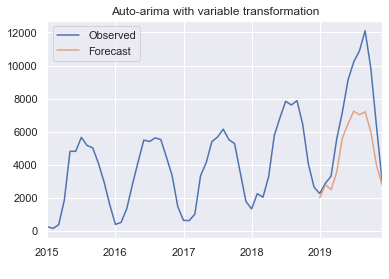

In [309]:
arima_model = auto_arima(train_m_t, seasonal=True, m=12)
print(arima_model.summary())


y_arima_forecast = arima_model.predict(n_periods=12)
auto=pd.Series(scipy.special.inv_boxcox(y_arima_forecast, 0.5), index=monthly_ave.index[48:])
ax = monthly_ave.plot(label='Observed')
auto.plot(ax=ax, label='Forecast', alpha=.7)
plt.legend()
plt.title("Auto-arima with variable transformation")
plt.xlabel(" ")
plt.show()


## Exponential Smoothing

In [315]:
model_exp_add = ExponentialSmoothing(monthly_ave[:48], trend="add", seasonal="add", seasonal_periods=12)
model_exp_add_damp = ExponentialSmoothing(monthly_ave[:48], trend="add", seasonal="add", seasonal_periods=12, damped=True)
model_exp_add_mult = ExponentialSmoothing(monthly_ave[:48], trend="add", seasonal="mul", seasonal_periods=12)
model_exp_add_mult_damp = ExponentialSmoothing(monthly_ave[:48], trend="add", seasonal="mul", seasonal_periods=12, damped=True)
model_exp_mult = ExponentialSmoothing(monthly_ave[:48], trend="mul", seasonal="mul", seasonal_periods=12)
                                           
result_EA= model_exp_add.fit()
pred_EA = result_EA.forecast(12)

result_EAD= model_exp_add_damp.fit()
pred_EAD = result_EAD.forecast(12)

result_EAM= model_exp_add_mult.fit()
pred_EAM = result_EAM.forecast(12)

result_EAMD= model_exp_add_mult_damp.fit()
pred_EAMD = result_EAMD.forecast(12)

result_EM= model_exp_mult.fit()
pred_EM = result_EM.forecast(12)



In [319]:
model_exp_add_t = ExponentialSmoothing(monthly_ave_t[:48], trend="add", seasonal="add", seasonal_periods=12)
model_exp_add_damp_t = ExponentialSmoothing(monthly_ave_t[:48], trend="add", seasonal="add", seasonal_periods=12, damped=True)
model_exp_add_mult_t = ExponentialSmoothing(monthly_ave_t[:48], trend="add", seasonal="mul", seasonal_periods=12)
model_exp_add_mult_damp_t = ExponentialSmoothing(monthly_ave_t[:48], trend="add", seasonal="mul", seasonal_periods=12, damped=True)
model_exp_mult_t = ExponentialSmoothing(monthly_ave_t[:48], trend="mul", seasonal="mul", seasonal_periods=12)
                                           
result_EA_t= model_exp_add_t.fit()
pred_EA_t = result_EA_t.forecast(12)

result_EAD_t= model_exp_add_damp_t.fit()
pred_EAD_t = result_EAD_t.forecast(12)

result_EAM_t= model_exp_add_mult_t.fit()
pred_EAM_t = result_EAM_t.forecast(12)

result_EAMD_t= model_exp_add_mult_damp_t.fit()
pred_EAMD_t = result_EAMD_t.forecast(12)

result_EM_t= model_exp_mult_t.fit()
pred_EM_t = result_EM_t.forecast(12)



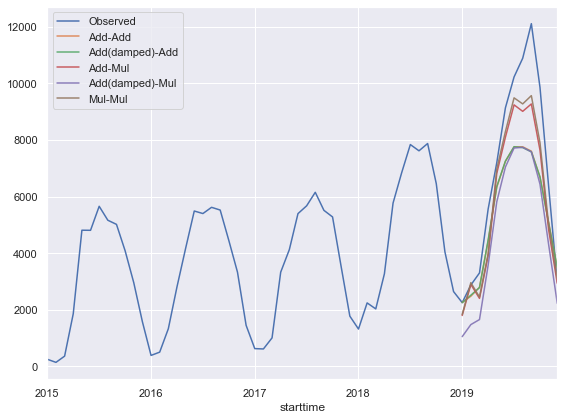

RMSE:  4507849.005641361
RMSE:  4524602.630175351
RMSE:  2062055.37849256
RMSE:  5789960.926183112
RMSE:  1616104.1552940048


In [323]:
pred_EA_series=pd.Series(pred_EA, index=monthly.index[48:])
pred_EAD_series=pd.Series(pred_EAD, index=monthly.index[48:])
pred_EAM_series=pd.Series(pred_EAM, index=monthly.index[48:])
pred_EAMD_series=pd.Series(pred_EAMD, index=monthly.index[48:])
pred_EM_series=pd.Series(pred_EM, index=monthly.index[48:])

#pred_ci4conv=pd.DataFrame(scipy.special.inv_boxcox(pred_ci4,0.5), index=pred4.predicted_mean.index)
fig,ax = plt.subplots(figsize=(8,6))
monthly_ave.plot(ax=ax, label='Observed')
pred_EA_series.plot(ax=ax, label='Add-Add', alpha=.9)
pred_EAD_series.plot(ax=ax, label='Add(damped)-Add', alpha=.9)
pred_EAM_series.plot(ax=ax, label='Add-Mul', alpha=.9)
pred_EAMD_series.plot(ax=ax, label='Add(damped)-Mul', alpha=.9)
pred_EM_series.plot(ax=ax, label='Mul-Mul', alpha=.9)

#ax.fill_between(pred_ci4conv.index,
                #pred_ci4conv.iloc[:, 0],
                #pred_ci4conv.iloc[:, 1], color='r', alpha=.2)
plt.legend()
plt.tight_layout()
plt.show()


print("RMSE: ", mean_squared_error(monthly_ave[48:],pred_EA_series))
print("RMSE: ", mean_squared_error(monthly_ave[48:],pred_EAD_series))
print("RMSE: ", mean_squared_error(monthly_ave[48:],pred_EAM_series))
print("RMSE: ", mean_squared_error(monthly_ave[48:],pred_EAMD_series))
print("RMSE: ", mean_squared_error(monthly_ave[48:],pred_EM_series))


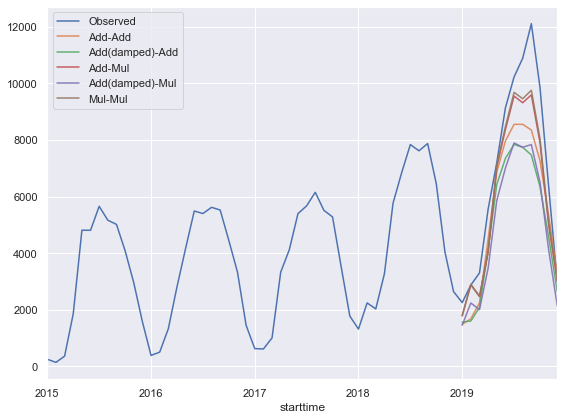

RMSE:  2991115.011522299
RMSE:  5175983.8239286775
RMSE:  1570351.889891472
RMSE:  5320403.850624376
RMSE:  1361824.9131583415


In [324]:
pred_EA_series_t=pd.Series(scipy.special.inv_boxcox(pred_EA_t, 0.5), index=monthly.index[48:])
pred_EAD_series_t=pd.Series(scipy.special.inv_boxcox(pred_EAD_t, 0.5), index=monthly.index[48:])
pred_EAM_series_t=pd.Series(scipy.special.inv_boxcox(pred_EAM_t, 0.5), index=monthly.index[48:])
pred_EAMD_series_t=pd.Series(scipy.special.inv_boxcox(pred_EAMD_t, 0.5), index=monthly.index[48:])
pred_EM_series_t=pd.Series(scipy.special.inv_boxcox(pred_EM_t, 0.5), index=monthly.index[48:])

#pred_ci4conv=pd.DataFrame(scipy.special.inv_boxcox(pred_ci4,0.5), index=pred4.predicted_mean.index)
fig,ax = plt.subplots(figsize=(8,6))
monthly_ave.plot(ax=ax, label='Observed')
pred_EA_series_t.plot(ax=ax, label='Add-Add', alpha=.9)
pred_EAD_series_t.plot(ax=ax, label='Add(damped)-Add', alpha=.9)
pred_EAM_series_t.plot(ax=ax, label='Add-Mul', alpha=.9)
pred_EAMD_series_t.plot(ax=ax, label='Add(damped)-Mul', alpha=.9)
pred_EM_series_t.plot(ax=ax, label='Mul-Mul', alpha=.9)

#ax.fill_between(pred_ci4conv.index,
                #pred_ci4conv.iloc[:, 0],
                #pred_ci4conv.iloc[:, 1], color='r', alpha=.2)
plt.legend()
plt.tight_layout()
plt.show()


print("RMSE: ", mean_squared_error(monthly_ave[48:],pred_EA_series_t))
print("RMSE: ", mean_squared_error(monthly_ave[48:],pred_EAD_series_t))
print("RMSE: ", mean_squared_error(monthly_ave[48:],pred_EAM_series_t))
print("RMSE: ", mean_squared_error(monthly_ave[48:],pred_EAMD_series_t))
print("RMSE: ", mean_squared_error(monthly_ave[48:],pred_EM_series_t))


## TBATS

In [ ]:
estimator = TBATS(
        seasonal_periods=[7, 365.25],
        use_arma_errors=None,  # shall try models with and without ARMA
        use_box_cox=False,  # will not use Box-Cox
        use_trend=None,  # will try models with trend and without it
        use_damped_trend=None,  # will try models with daming and without it
        show_warnings=False,  # will not be showing any warnings for chosen model
    )
fitted_model = estimator.fit(daily[:(len(daily)-365)])


y_forecast = fitted_model.forecast(steps=365)

ax = daily.plot(label='Observed', figsize=(16,4))
tbatsforecast=pd.Series(y_forecast, index=daily.index[(len(daily)-365):])
tbatsforecast.plot(ax=ax, label='Forecast', alpha=.7)

In [ ]:
fitted_model_t = estimator.fit(daily_t[:(len(daily)-365)])


y_forecast_t = fitted_model_t.forecast(steps=365)

ax = daily.plot(label='Observed', figsize=(16,4))
tbatsforecast_t=pd.Series(scipy.special.inv_boxcox(y_forecast_t, 0.5)-1, index=daily.index[(len(daily)-365):])
tbatsforecast_t.plot(ax=ax, label='Forecast', alpha=.7)

## SARIMA with exogeneous variables

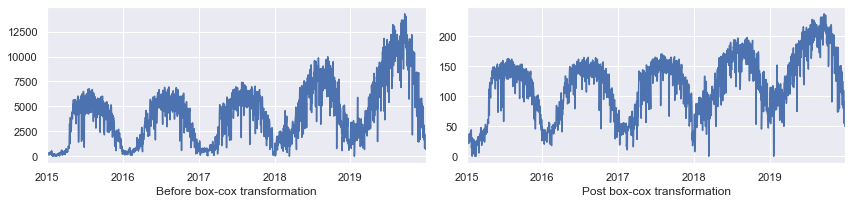

In [284]:
daily_t=pd.Series(scipy.stats.boxcox(daily+1, lmbda=0.5), index=daily.index)
fig, axes=plt.subplots(1,2, figsize=(12,3))
daily.plot(ax=axes[0])
axes[0].set_xlabel("Before box-cox transformation")
daily_t.plot(ax=axes[1])
axes[1].set_xlabel("Post box-cox transformation")
plt.tight_layout()
plt.show()

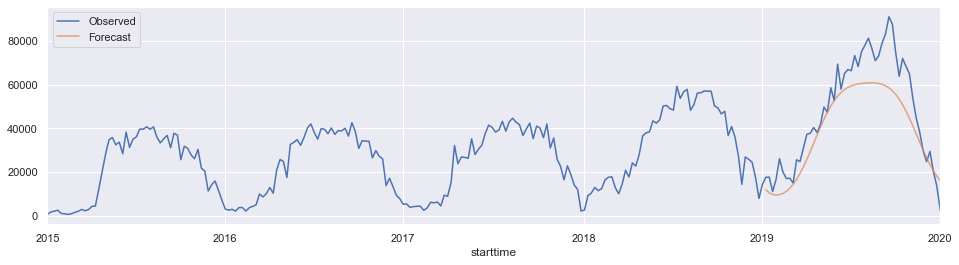

In [294]:
weekly_t=pd.Series(scipy.stats.boxcox(weekly, lmbda=0.5), index=weekly.index)
exog = pd.DataFrame({'date': weekly.index})
exog = exog.set_index(pd.PeriodIndex(exog['date'], freq='W'))
exog['sin365'] = np.sin(2 * np.pi * exog.index.weekofyear / 52.1429)
exog['cos365'] = np.cos(2 * np.pi * exog.index.weekofyear / 52.1429)
exog['sin365_2'] = np.sin(4 * np.pi * exog.index.weekofyear / 52.1429)
exog['cos365_2'] = np.cos(4 * np.pi * exog.index.weekofyear / 52.1429)
exog = exog.drop(columns=['date'])

exog_to_train = exog.iloc[:(len(weekly_t)-52)]
exog_to_test = exog.iloc[(len(weekly_t)-52):]
# Fit model
arima_exog_model = auto_arima(y=weekly_t[:(len(weekly)-52)], exogenous=exog_to_train, seasonal=True, m=## SARIMA with exogeneous variables)
# Forecast
y_arima_exog_forecast = arima_exog_model.predict(n_periods=52, exogenous=exog_to_test)

autoexog = pd.Series(scipy.special.inv_boxcox(y_arima_exog_forecast, 0.5), index=weekly.index[(len(weekly)-52):])
ax = weekly.plot(label='Observed', figsize=(16,4))
autoexog.plot(ax=ax, label='Forecast', alpha=.7)

plt.legend()
plt.show()

In [295]:
arima_exog_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  210
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -990.740
Date:                Sat, 14 Mar 2020   AIC                           1997.481
Time:                        17:40:36   BIC                           2024.219
Sample:                    01-04-2015   HQIC                          2008.291
                         - 01-06-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3005      0.103      2.921      0.003       0.099       0.502
sin365       -81.0207      6.998    -11.578      0.000     -94.736     -67.306
cos365      -116.7926      6.039    -19.340      0.000    -128.629    -104.957
sin365_2     -28.9053      5.455     -5.299      0.000     -39.596     -18.215
cos365_2     -10.3854      5.766     -1.801      0.072     -21.687       0.916
ar.L1          0.4991      0.054      9.224      0.000       0.393       0.605
ma.L1         -0.9643      0.024    -39.582      0.000      -1.012      -0.917
sigma2       761.3060     65.341     11.651      0.000     633.239     889.373
===================================================================================
Ljung-Box (Q):                       36.47   Jarque-Bera (JB):                10.10
Prob(Q):                              0.63   Prob(JB):                         0.01
Heteroskedasticity (H):               1.34   Skew:                            -0.11
Prob(H) (two-sided):                  0.23   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

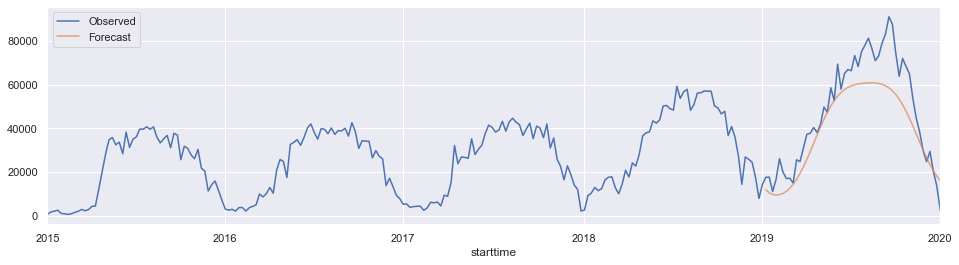

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  210
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -990.740
Date:                Sat, 14 Mar 2020   AIC                           1997.481
Time:                        17:41:19   BIC                           2024.219
Sample:                    01-04-2015   HQIC                          2008.291
                         - 01-06-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3005      0.103      2.921      0.003       0.099       0.502
sin365       -81.0207      6.998    -11.578      0.000     -94.736     -67.306
cos365      -116.7926      6.039    -19.340      0.000    -128.629    -104.957
sin365_2     -28.9053      5.455     -5.299      0.000     -39.596     -18.215
cos365_2     -10.3854      5.766     -1.801      0.072     -21.687       0.916
ar.L1          0.4991      0.054      9.224      0.000       0.393       0.605
ma.L1         -0.9643      0.024    -39.582      0.000      -1.012      -0.917
sigma2       761.3060     65.341     11.651      0.000     633.239     889.373
===================================================================================
Ljung-Box (Q):                       36.47   Jarque-Bera (JB):                10.10
Prob(Q):                              0.63   Prob(JB):                         0.01
Heteroskedasticity (H):               1.34   Skew:                            -0.11
Prob(H) (two-sided):                  0.23   Kurtosis:                         4.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [296]:
# No seasonal 
arima_exog_model_ns = auto_arima(y=weekly_t[:(len(weekly)-52)], exogenous=exog_to_train)
# Forecast
y_arima_exog_forecast_ns = arima_exog_model_ns.predict(n_periods=52, exogenous=exog_to_test)

autoexog_ns = pd.Series(scipy.special.inv_boxcox(y_arima_exog_forecast_ns, 0.5), index=weekly.index[(len(weekly)-52):])
ax = weekly.plot(label='Observed', figsize=(16,4))
autoexog_ns.plot(ax=ax, label='Forecast', alpha=.7)

plt.legend()
plt.show()
arima_exog_model_ns.summary()

In [ ]:

exog_d= pd.DataFrame({'date': daily.index})
exog_d = exog_d.set_index(pd.PeriodIndex(exog_d['date'], freq='D'))
exog_d['sin365'] = np.sin(2 * np.pi * exog_d.index.dayofyear / 365.25)
exog_d['cos365'] = np.cos(2 * np.pi * exog_d.index.dayofyear / 365.25)
exog_d['sin365_2'] = np.sin(4 * np.pi * exog_d.index.dayofyear / 365.25)
exog_d['cos365_2'] = np.cos(4 * np.pi * exog_d.index.dayofyear / 365.25)
exog_d = exog_d.drop(columns=['date'])

exog_to_train_d = exog_d.iloc[:(len(daily_t)-365)]
exog_to_test_d = exog_d.iloc[(len(daily_t)-365):]

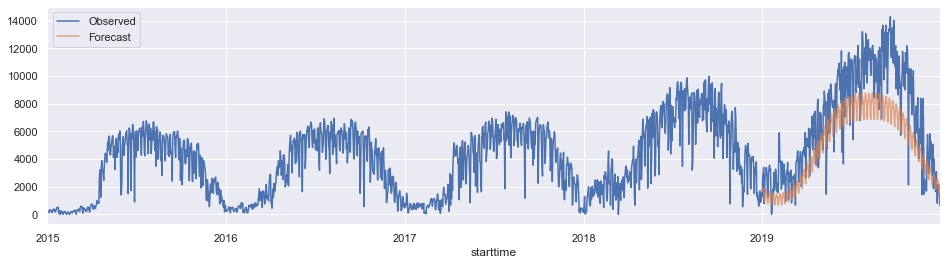

In [290]:
# Fit model
arima_exog_model_d = auto_arima(y=daily_t[:(len(daily)-365)], exogenous=exog_to_train_d, seasonal=True, m=7)
# Forecast
y_arima_exog_forecast_d = arima_exog_model_d.predict(n_periods=365, exogenous=exog_to_test_d)

autoexog_d = pd.Series(scipy.special.inv_boxcox(y_arima_exog_forecast_d, 0.5)-1, index=daily.index[(len(daily)-365):])
ax = daily.plot(label='Observed', figsize=(16,4))
autoexog_d.plot(ax=ax, label='Forecast', alpha=.7)

plt.legend()
plt.show()

In [291]:
arima_exog_model_d.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1461
Model:             SARIMAX(3, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -6120.170
Date:                           Sat, 14 Mar 2020   AIC                          12264.339
Time:                                   17:39:21   BIC                          12327.774
Sample:                               01-01-2015   HQIC                         12288.003
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0001      0.000      0.325      0.745      -0.001       0.001
sin365       -28.4304      2.486    -11.436      0.000     -33.303     -23.558
cos365       -46.0839      2.056    -22.413      0.000     -50.114     -42.054
sin365_2     -10.4847      1.553     -6.749      0.000     -13.530      -7.440
cos365_2      -5.0293      1.489     -3.377      0.001      -7.948      -2.110
ar.L1          0.4026      0.022     18.136      0.000       0.359       0.446
ar.L2          0.0013      0.029      0.045      0.964      -0.055       0.058
ar.L3          0.1304      0.024      5.398      0.000       0.083       0.178
ma.L1         -0.9773      0.006   -157.191      0.000      -0.989      -0.965
ar.S.L7        0.9939      0.003    313.223      0.000       0.988       1.000
ma.S.L7       -0.9546      0.012    -76.924      0.000      -0.979      -0.930
sigma2       244.0371      5.726     42.616      0.000     232.813     255.261
===================================================================================
Ljung-Box (Q):                       54.42   Jarque-Bera (JB):              2146.46
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                            -1.56
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.05
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""